## Importing Libraries

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf

## Importing Dataset

In [ ]:
!wget https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
!unzip -q lol_dataset.zip && rm lol_dataset.zip

--2024-12-13 15:30:50--  https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
Resolving huggingface.co (huggingface.co)... 3.165.160.61, 3.165.160.12, 3.165.160.11, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.61|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/d9/09/d909ef7668bb417b7065a311bd55a3084cc83a1f918e13cb41c5503328432db2/419fddc48958cd0f5599939ee0248852a37ceb8bb738c9b9525e95b25a89de9a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27lol_dataset.zip%3B+filename%3D%22lol_dataset.zip%22%3B&response-content-type=application%2Fzip&Expires=1734363050&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNDM2MzA1MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kOS8wOS9kOTA5ZWY3NjY4YmI0MTdiNzA2NWEzMTFiZDU1YTMwODRjYzgzYTFmOTE4ZTEzY2I0MWM1NTAzMzI4NDMyZGIyLzQxOWZkZGM0ODk1OGNkMGY1NTk5OTM5ZWUwMjQ4ODUyYTM3Y2ViOGJiNzM4YzliOTUyN

## Data Pre-Processing

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400


def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image/255.0
    return image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))


train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


## Building the Model


In [ ]:
def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)


## Defining the Loss Functions

In [ ]:

def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = (
        mean_rgb[:, :, :, 0],
        mean_rgb[:, :, :, 1],
        mean_rgb[:, :, :, 2],
    )
    d_rg = tf.multiply(mr - mg, mr - mg)
    d_rb = tf.multiply(mr - mb, mr - mb)
    d_gb = tf.multiply(mb - mg, mb - mg)
    return tf.sqrt(tf.multiply(d_rg, d_rg) + tf.multiply(d_rb, d_rb) + tf.multiply(d_gb, d_gb))


In [ ]:

def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.multiply(mean - mean_val, mean - mean_val))



In [ ]:

def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.multiply(x[:, 1:, :, :] - x[:, : h_x - 1, :, :], x[:, 1:, :, :] - x[:, : h_x - 1, :, :]))
    w_tv = tf.reduce_sum(tf.multiply(x[:, :, 1:, :] - x[:, :, : w_x - 1, :], x[:, :, 1:, :] - x[:, :, : w_x - 1, :]))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size


In [ ]:

class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):
        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_right = tf.nn.conv2d(
            original_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_left = tf.multiply(d_original_left - d_enhanced_left, d_original_left - d_enhanced_left)
        d_right = tf.multiply(d_original_right - d_enhanced_right, d_original_right - d_enhanced_right)
        d_up = tf.multiply(d_original_up - d_enhanced_up, d_original_up - d_enhanced_up)
        d_down = tf.multiply(d_original_down - d_enhanced_down, d_original_down - d_enhanced_down)

        return d_left + d_right + d_up + d_down


## Custom Zero-DCE Model with Loss Functions and Training Methods

In [ ]:

class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate=1e-4, **kwargs):
        super().compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.illumination_smoothness_loss_tracker = keras.metrics.Mean(
            name="illumination_smoothness_loss"
        )
        self.spatial_constancy_loss_tracker = keras.metrics.Mean(
            name="spatial_constancy_loss"
        )
        self.color_constancy_loss_tracker = keras.metrics.Mean(
            name="color_constancy_loss"
        )
        self.exposure_loss_tracker = keras.metrics.Mean(name="exposure_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.illumination_smoothness_loss_tracker,
            self.spatial_constancy_loss_tracker,
            self.color_constancy_loss_tracker,
            self.exposure_loss_tracker,
        ]

    def get_enhanced_image(self, data, output):
        filters = tf.eye(24)
        r1 = tf.reshape(filters[0:3], [1, 1, 24, 3])    
        r2 = tf.reshape(filters[3:6], [1, 1, 24, 3])    
        r3 = tf.reshape(filters[6:9], [1, 1, 24, 3])    
        r4 = tf.reshape(filters[9:12], [1, 1, 24, 3])   
        r5 = tf.reshape(filters[12:15], [1, 1, 24, 3])  
        r6 = tf.reshape(filters[15:18], [1, 1, 24, 3])  
        r7 = tf.reshape(filters[18:21], [1, 1, 24, 3])  
        r8 = tf.reshape(filters[21:24], [1, 1, 24, 3])
        r1_out = tf.nn.conv2d(output, r1, strides=1, padding='VALID')
        r2_out = tf.nn.conv2d(output, r2, strides=1, padding='VALID')
        r3_out = tf.nn.conv2d(output, r3, strides=1, padding='VALID')
        r4_out = tf.nn.conv2d(output, r4, strides=1, padding='VALID')
        r5_out = tf.nn.conv2d(output, r5, strides=1, padding='VALID')
        r6_out = tf.nn.conv2d(output, r6, strides=1, padding='VALID')
        r7_out = tf.nn.conv2d(output, r7, strides=1, padding='VALID')
        r8_out = tf.nn.conv2d(output, r8, strides=1, padding='VALID')
        x = data + r1_out * (tf.multiply(data, data) - data)
        x = x + r2_out * (tf.multiply(x, x) - x)
        x = x + r3_out * (tf.multiply(x, x) - x)
        enhanced_image = x + r4_out * (tf.multiply(x, x) - x)
        x = enhanced_image + r5_out * (tf.multiply(enhanced_image, enhanced_image) - enhanced_image)
        x = x + r6_out * (tf.multiply(x, x) - x)
        x = x + r7_out * (tf.multiply(x, x) - x)
        enhanced_image = x + r8_out * (tf.multiply(x, x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )

        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)

        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def test_step(self, data):
        output = self.dce_model(data)
        losses = self.compute_losses(data, output)

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


## Model Training

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 371ms/step - color_constancy_loss: 0.0030 - exposure_loss: 3.0025 - illumination_smoothness_loss: 2.7384 - spatial_constancy_loss: 5.9870e-06 - total_loss: 5.7439 - val_color_constancy_loss: 0.0025 - val_exposure_loss: 2.9454 - val_illumination_smoothness_loss: 3.5559 - val_spatial_constancy_loss: 1.1374e-05 - val_total_loss: 6.5037
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - color_constancy_loss: 0.0031 - exposure_loss: 2.9797 - illumination_smoothness_loss: 1.6371 - spatial_constancy_loss: 1.7642e-05 - total_loss: 4.6199 - val_color_constancy_loss: 0.0023 - val_exposure_loss: 2.9347 - val_illumination_smoothness_loss: 2.4420 - val_spatial_constancy_loss: 2.5677e-05 - val_total_loss: 5.3789
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - color_constancy_loss: 0.0030 - exposure_loss: 2.9709 - illumination_smoothness_loss: 1.1110 - spatial_constancy_loss: 2.9646e-05 - total_loss: 4.0850 - val_color_constancy_loss: 0.0023 - val_

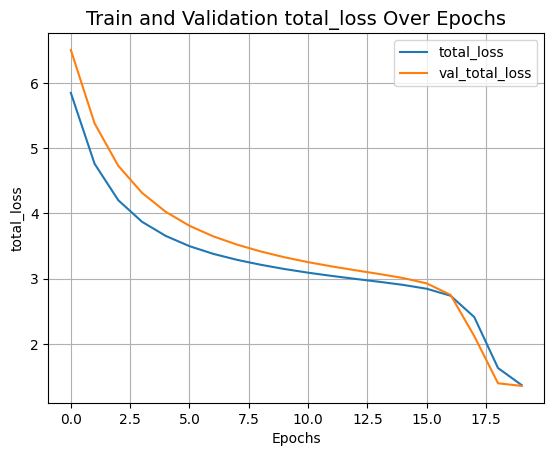

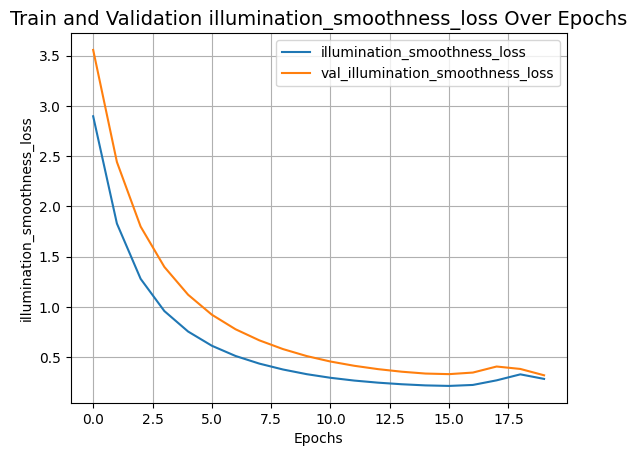

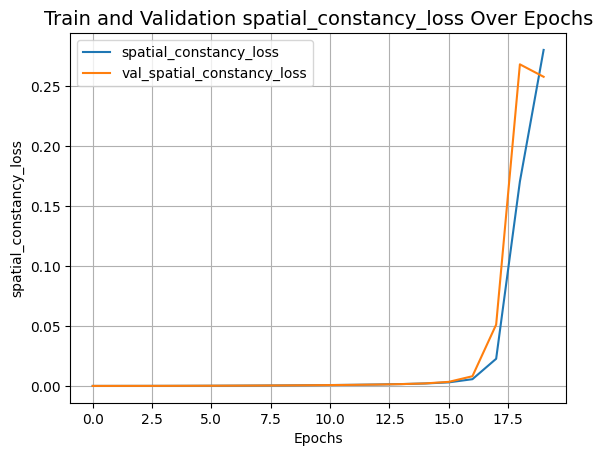

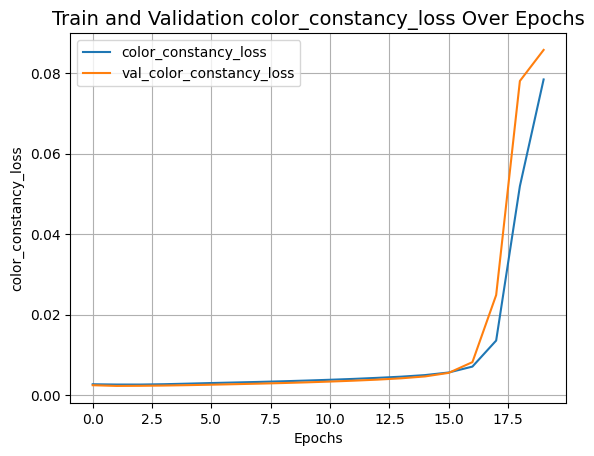

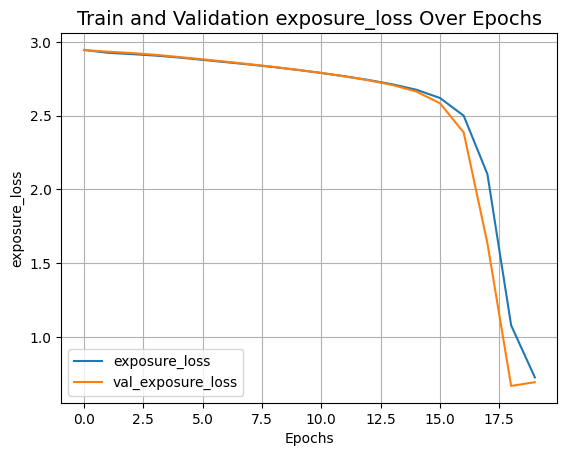

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=20)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

zero_dce_model.save("zero_dce_model.h5")


## Inference Functions

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

def infer(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image


## Sample Inputs and Enhanced Outputs

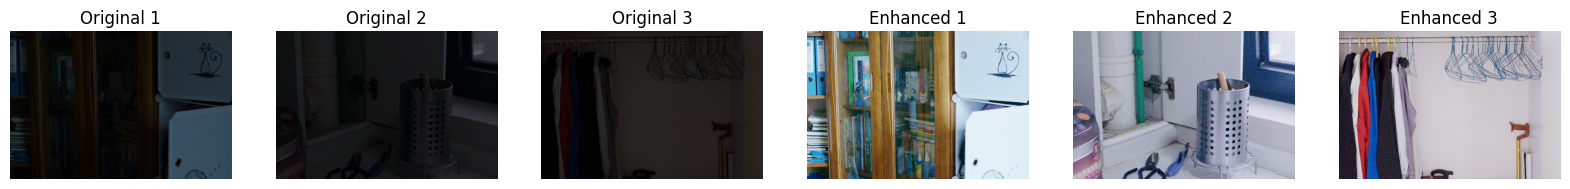

In [ ]:
import numpy as np
from PIL import Image

def plot_output(test_low_light_images):
    samples_original = []
    samples_enhanced = []

    for idx, val_image_file in enumerate(test_low_light_images):
        original_image = Image.open(val_image_file)
        enhanced_image = infer(original_image)

        original_image_np = np.array(original_image).astype(np.float32)
        enhanced_image_np = np.array(enhanced_image).astype(np.float32)

        if len(samples_original) < 3:
            samples_original.append(original_image)
            samples_enhanced.append(enhanced_image)

    # Plot 3 sample images (Original vs Enhanced)
    if samples_original and samples_enhanced:
        plot_results(
            [samples_original[0], samples_original[1], samples_original[2],
             samples_enhanced[0], samples_enhanced[1], samples_enhanced[2]],
            ["Original 1", "Original 2", "Original 3",
             "Enhanced 1", "Enhanced 2", "Enhanced 3"],
            (20, 12)
        )

plot_output(test_low_light_images)


## Converting model to TFLite

In [ ]:
import tensorflow as tf

# Assuming 'zero_dce_model' is already trained
converter = tf.lite.TFLiteConverter.from_keras_model(zero_dce_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()
# Save the converted model to a .tflite file
with open('zero_dce_model_non_opti.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")

Saved artifact at '/tmp/tmp0r4902_i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None)
Captures:
  133965599645136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133965599647600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133965600407072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133965600395456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133965600392816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133965600398976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133965600401440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133965600397744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133968349398992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133965600402672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13396560039686